## Importing libraries and reading data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from pathlib import Path
from rdkit import Chem
from rdkit.Chem import Draw, Descriptors, rdMolDescriptors

In [2]:
HERE = Path(_dh[-1])
DATA_PATH = HERE.parent.parent/'model_creation'/'data'/'fda_approved'

# Importing descriptors + structures without any NA
drugs_rdkit = pd.read_csv(DATA_PATH/'fda_rdkit_pre_processed_descriptors.csv')
drugs_rdkit

,name,chembl_id,clean_smiles,first_approval_year,indication_class,molecule_type,withdrawn_flag,therapeutic_flag,polymer_flag,inorganic_flag,...,fr_quatN,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiophene,fr_unbrch_alkane,fr_urea
0,GUANIDINE HYDROCHLORIDE,CHEMBL1200728,N=C(N)N,1939,NaN,Small molecule,False,True,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ACETOHYDROXAMIC ACID,CHEMBL734,CC(=O)NO,1983,Enzyme Inhibitor (urease),Small molecule,False,True,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,HYDROXYUREA,CHEMBL467,NC(=O)NO,1967,Antineoplastic,Small molecule,False,True,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,CYSTEAMINE,CHEMBL602,NCCS,1994,CYSTEAMINE HYDROCHLORIDE,Small molecule,False,True,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,DIMETHYL SULFOXIDE,CHEMBL504,C[S+](C)[O-],1978,Anti-Inflammatory (topical),Small molecule,False,True,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1890,BLEOMYCIN,CHEMBL403664,Cc1c(N)nc([C@H](CC(N)=O)NC[C@H](N)C(N)=O)nc1C(...,1973,BLEOMYCIN SULFATE,Small molecule,False,True,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0
1891,VANCOMYCIN,CHEMBL262777,CN[C@H](CC(C)C)C(=O)N[C@H]1C(=O)N[C@@H](CC(N)=...,1964,VANCOMYCIN HYDROCHLORIDE,Small molecule,False,True,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1892,COLISTIMETHATE SODIUM,CHEMBL1201441,CCC(C)CCCCC(=O)NC(CCNCS(=O)(=O)O)C(=O)NC(C(=O)...,1970.0,Antibacterial,Small molecule,False,True,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0
1893,TELAVANCIN,CHEMBL507870,CCCCCCCCCCNCCN[C@@]1(C)C[C@H](O[C@H]2[C@H](Oc3...,2009,TELAVANCIN HYDROCHLORIDE,Small molecule,False,True,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0


## Datasets for dimensionality reduction

In [3]:
response_variables = drugs_rdkit.iloc[:,:14]
print(f'Response variables: {response_variables.columns} and its shape {response_variables.shape}')

descriptors = drugs_rdkit.iloc[:,14:]
print(f'\nSome descriptors columns: {descriptors.columns} and its shape: {descriptors.shape}')

Response variables: Index(['name', 'chembl_id', 'clean_smiles', 'first_approval_year',
       'indication_class', 'molecule_type', 'withdrawn_flag',
       'therapeutic_flag', 'polymer_flag', 'inorganic_flag',
       'natural_product_flag', 'parenteral', 'topical', 'oral'],
      dtype='object') and its shape (1895, 14)

Some descriptors columns: Index(['MaxEStateIndex', 'MinEStateIndex', 'MaxAbsEStateIndex',
       'MinAbsEStateIndex', 'qed', 'MolWt', 'HeavyAtomMolWt', 'ExactMolWt',
       'NumValenceElectrons', 'NumRadicalElectrons',
       ...
       'fr_quatN', 'fr_sulfide', 'fr_sulfonamd', 'fr_sulfone',
       'fr_term_acetylene', 'fr_tetrazole', 'fr_thiazole', 'fr_thiophene',
       'fr_unbrch_alkane', 'fr_urea'],
      dtype='object', length=201) and its shape: (1895, 201)


### Datasets for dimensionality reduction

In this step, I'm going to **separate** two subset of descriptors for dimensionality reduction:
* All the descriptors (RDKit) + 'oral and natural product' response variables
* Some **heuristic** descriptors (such as HBD, HBA, #Ar, etc) + 'oral and natural product' response variables

We have to calculate the heuristic/rule-based descriptors aside from all the descriptors, as they habe different names.

#### Rule-based descriptors

In [4]:
# Defining the rule-based (heuristic) descriptors
rule_based_descriptors = [
    'ExactMW',
    'FractionCSP3',
    'NumAliphaticHeterocycles',
    'NumAliphaticRings',
    'NumAmideBonds',
    'NumAromaticHeterocycles',
    'NumAromaticRings',
    'NumAtomStereocenters',
    'NumAtoms',
    'NumBridgeheadAtoms',
    'NumHBA',
    'NumHBD',
    'NumHeavyAtoms',
    'NumHeteroatoms',
    'NumHeterocycles',
    'LipinskiHBA',
    'LipinskiHBD',
    'NumRings',
    'NumRotatableBonds',
    'NumSaturatedRings',
    'TPSA',
    'CrippenClogP'
]

rule_based_descriptors = [desc.lower() for desc in rule_based_descriptors]
descriptor_names = list(rdMolDescriptors.Properties.GetAvailableProperties())

# Getting the actual name of the property (descriptor)
rule_based_properties = [desc for desc in descriptor_names if desc.lower() in rule_based_descriptors]
rule_based_descriptors = rule_based_properties
print(rule_based_descriptors)

['exactmw', 'lipinskiHBA', 'lipinskiHBD', 'NumRotatableBonds', 'NumHBD', 'NumHBA', 'NumHeavyAtoms', 'NumAtoms', 'NumHeteroatoms', 'NumAmideBonds', 'FractionCSP3', 'NumRings', 'NumAromaticRings', 'NumAliphaticRings', 'NumSaturatedRings', 'NumHeterocycles', 'NumAromaticHeterocycles', 'NumAliphaticHeterocycles', 'NumBridgeheadAtoms', 'NumAtomStereoCenters', 'tpsa', 'CrippenClogP']


In [5]:
def compute_rule_based_descriptors(smiles:str, descriptors_list:str) -> dict:
    """
    Manually compute rule-based/heuristic descriptors from a list of descriptors using SMILES.
    smiles:  SMILES string
    descriptors_list: list of descriptors
    """
    descriptor_calculator = rdMolDescriptors.Properties(descriptors_list)

    descriptors_dict = {}
    descriptors_dict['smiles'] = smiles
    mol = Chem.MolFromSmiles(smiles)

    for name, value in zip(descriptor_calculator.GetPropertyNames(), descriptor_calculator.ComputeProperties(mol)):
        descriptors_dict[name] = value
    
    return descriptors_dict

In [6]:
# Instatiating descriptors list and smiles list
manual_descriptors_list = rule_based_descriptors
smiles_list = response_variables['clean_smiles'].to_list()

# Calculate heuristic-based descriptors
descriptors_result = []
for smiles in smiles_list:
    descriptors_result.append(compute_rule_based_descriptors(smiles, manual_descriptors_list))


#### '`Rule-based`' and '`All descriptors`'

In [7]:
# Rule based descriptors matrix    
rule_based_descriptors = pd.DataFrame(descriptors_result)
# Excluding smiles column
rule_based_descriptors = rule_based_descriptors.iloc[:, 1:]

rules_dataset = pd.concat([rule_based_descriptors,response_variables['oral']],axis=1)
rules_dataset.head(3)

,exactmw,lipinskiHBA,lipinskiHBD,NumRotatableBonds,NumHBD,NumHBA,NumHeavyAtoms,NumAtoms,NumHeteroatoms,NumAmideBonds,...,NumAliphaticRings,NumSaturatedRings,NumHeterocycles,NumAromaticHeterocycles,NumAliphaticHeterocycles,NumBridgeheadAtoms,NumAtomStereoCenters,tpsa,CrippenClogP,oral
0,59.048347,3.0,5.0,0.0,3.0,1.0,4.0,9.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,75.89,-1.16143,True
1,75.032028,3.0,2.0,0.0,2.0,2.0,5.0,10.0,3.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49.33,-0.48830,True
2,76.027277,4.0,4.0,0.0,3.0,2.0,5.0,9.0,4.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,75.35,-0.95610,True


In [8]:
# All descriptors
all_descriptors_dataset = pd.concat([descriptors, response_variables['oral']], axis=1)
all_descriptors_dataset.head(3)

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiophene,fr_unbrch_alkane,fr_urea,oral
0,6.055556,-0.333333,6.055556,0.333333,0.242956,59.072,54.032,59.048347,24.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True
1,9.451389,-0.439815,9.451389,0.439815,0.301333,75.067,70.027,75.032028,30.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True
2,9.229167,-0.939815,9.229167,0.939815,0.256644,76.055,72.023,76.027277,30.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,True


## Checking Missing Values

This step serves as a redundancy check, given that the majority of missing values have already been addressed during the preprocessing phase, but also for checking if any of the computed rule-based descriptors above yielded any missing value. Here, we aim to visually inspect for any remaining missing descriptors by utilizing a straightforward heatmap.

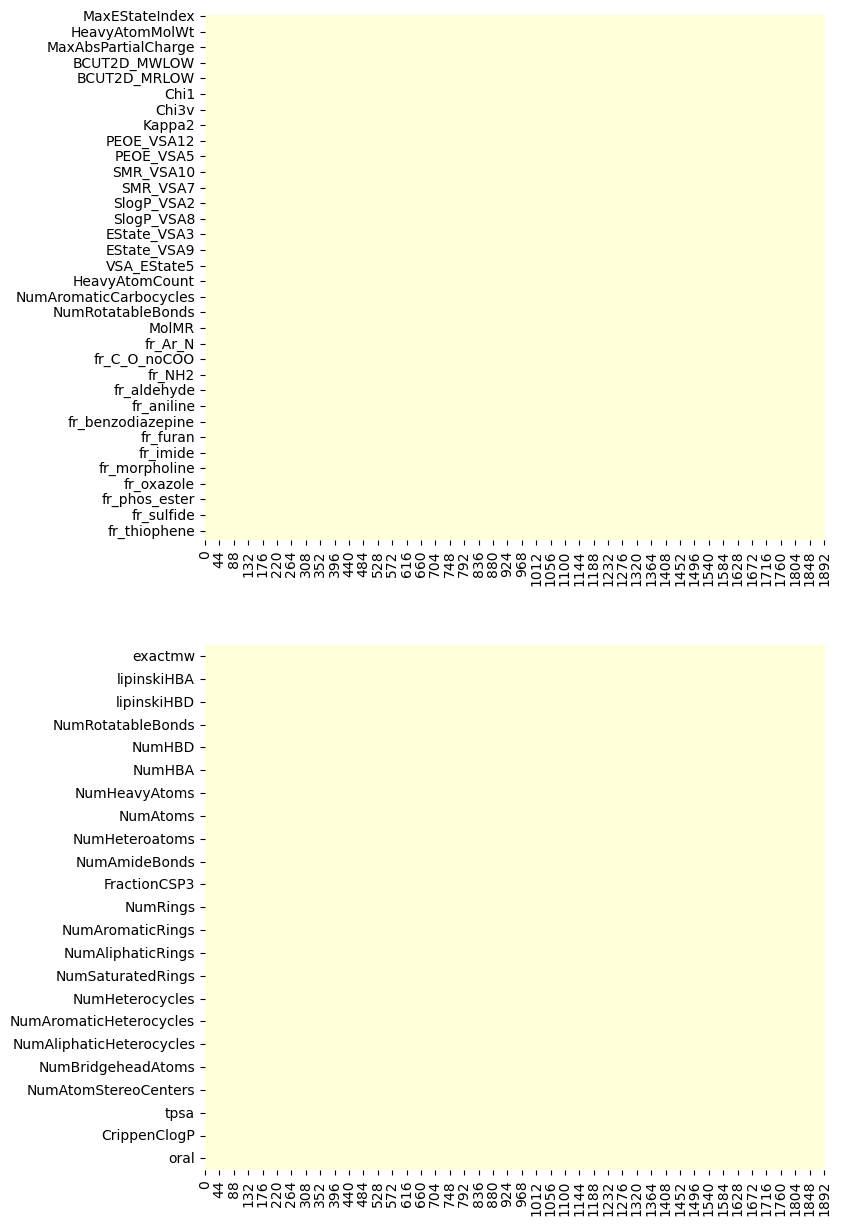

In [9]:
fig, axs = plt.subplots(2,1,figsize=(8,15))

missing_all_descriptors = sns.heatmap(all_descriptors_dataset.isna().transpose(), cmap='YlGnBu', cbar=False, ax= axs[0])
missing_rule_descriptors = sns.heatmap(rules_dataset.isna().transpose(), cmap='YlGnBu', cbar=False, ax= axs[1])

## Dimensionality reduction comments

The main steps for principal component analysis are:
1) Select the datset to use for dimensionality reduction
2) Scaling of X matrix
3) PCA fit and transform
4) Data Visualization
5) Possible 'chemical' interpretation of components

On the following sections, we're going to atempt to visualize if it is possible to use dimensionality reduction techniques (PCA/t-SNE) and different descriptors to distinguish Oral/Non-Oral, Natural/Synthetic, Topical/Other.

## PCA

### All descriptors

In [10]:
# X matrix
X_all_descriptors = all_descriptors_dataset.iloc[:,:-1]

# Scaling/Normalizing data
scaler = StandardScaler()
X_all_descriptors_scaled = scaler.fit_transform(X_all_descriptors)

# Principal Component Analysis
pca = PCA(n_components=10)
pca_all_rules = pca.fit_transform(X_all_descriptors_scaled)

In [11]:
# Defining labels
labels_mapping = {
    'oral': ['non oral', 'oral'],
    'natural_product_flag': ['synthetic', 'natural'],
    'topical': ['other', 'topical']
}

# Function to generate legend labels
def create_legend_labels(column_name):
    return [labels_mapping[column_name][point] for point in response_variables[column_name]]

legend_oral = create_legend_labels('oral')
legend_np = create_legend_labels('natural_product_flag')
legend_topical = create_legend_labels('topical')

In [12]:
# Data for dataframe
data = {
    'pc1': pca_all_rules[:, 0],
    'pc2': pca_all_rules[:, 1],
    'pc3': pca_all_rules[:, 2],
    'legend_oral': legend_oral,
    'legend_np': legend_np,
    'legend_topical': legend_topical,
}
# Conversion to df
pca_df = pd.DataFrame(data)

#### Plots

Text(0.5, 0.98, 'Chemical Space using PCA for all RDKit Descriptors')

<Figure size 640x480 with 0 Axes>

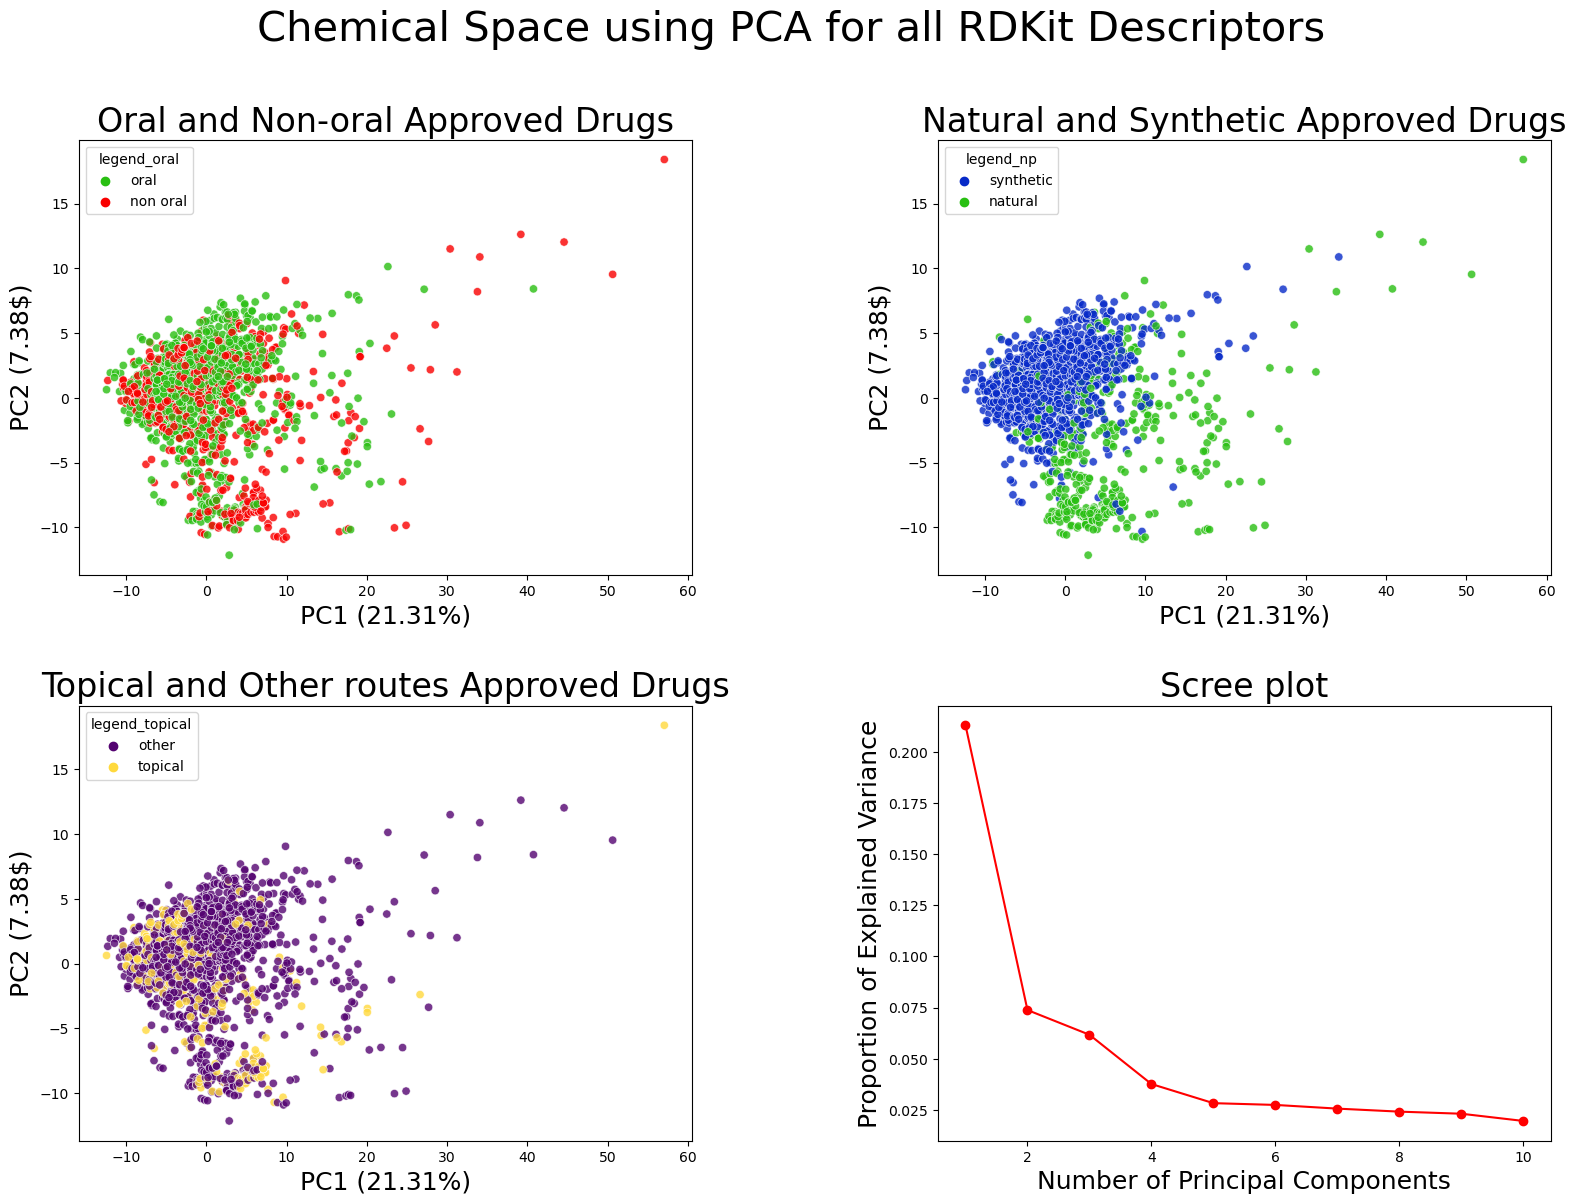

In [13]:
# PCA plots for oral/non oral, natural/synthetic and topical/other routes drugs
VAR_PC1 = round(list(pca.explained_variance_ratio_)[0]*100, 2)
VAR_PC2 = round(list(pca.explained_variance_ratio_)[1]*100, 2)
TITLE_FONT_SIZE = 24
AXIS_LABEL_FONT_SIZE = 18

plt.tight_layout()
n_rows, n_cols = 2, 2
fig, axs = plt.subplots(n_rows, n_cols, figsize=(19,13))

palettes = {
    'oral': {'oral': '#29bf12', 'non oral': '#f90000'},
    'np': {'synthetic': '#072ac8', 'natural': '#28bf12'},
    'topical': {'topical': '#FFD93d', 'other':'#540371'}
}

plot_titles = {
    'oral': 'Oral and Non-oral Approved Drugs',
    'np': 'Natural and Synthetic Approved Drugs',
    'topical': 'Topical and Other routes Approved Drugs'
}

# PCA plots
for i, category in enumerate(['oral', 'np', 'topical']):
    row = i // n_cols
    col = i % n_cols

    sns.scatterplot(data=pca_df, x='pc1', y='pc2', hue=f'legend_{category}', ax=axs[row][col],
    palette=palettes[category], alpha=0.8)
    axs[row][col].set_title(plot_titles[category], fontsize=TITLE_FONT_SIZE)
    axs[row][col].set_xlabel(f'PC1 ({VAR_PC1}%)', fontsize=AXIS_LABEL_FONT_SIZE)
    axs[row][col].set_ylabel(f'PC2 ({VAR_PC2}$)',fontsize=AXIS_LABEL_FONT_SIZE)

# Scree plot
PC_values = np.arange(pca.n_components_) + 1
axs[1][1].plot(PC_values, pca.explained_variance_ratio_, 'ro-')
axs[1][1].set_title('Scree plot', fontsize=TITLE_FONT_SIZE)
axs[1][1].set_xlabel('Number of Principal Components', fontsize=AXIS_LABEL_FONT_SIZE)
axs[1][1].set_ylabel('Proportion of Explained Variance', fontsize=AXIS_LABEL_FONT_SIZE)

# Final adjustments
fig.subplots_adjust(wspace=0.4, hspace=0.3)
fig.suptitle('Chemical Space using PCA for all RDKit Descriptors', fontsize=30)

#### 'Domain-Knowledge' interpretation of Components

In [14]:
# Component Interpretation
component_scores = []

for pc_number, component in enumerate(pca.components_[0:3]):
    component_column_score = (list(zip(component, X_all_descriptors.columns)))
    top_10_scores = (sorted(component_column_score, key=lambda x: abs(x[0]), reverse=True)[:10])

    component_scores.append({'Component': pc_number, 'Top_10_Scores': top_10_scores})

pd.DataFrame(component_scores).values

array([[0,
        list([(0.15040023060152935, 'NumValenceElectrons'), (0.1501503727065983, 'Chi0'), (0.14962273276120225, 'HeavyAtomCount'), (0.14885095728787284, 'LabuteASA'), (0.14876699449321093, 'Chi1'), (0.14851003967524168, 'ExactMolWt'), (0.14848296936274352, 'MolWt'), (0.14783257128261273, 'Chi0v'), (0.14769445549607493, 'HeavyAtomMolWt'), (0.14761659402049365, 'Chi0n')])],
       [1,
        list([(-0.20230762678725245, 'NumAliphaticCarbocycles'), (-0.19692338569391146, 'NumSaturatedCarbocycles'), (0.18875980088538244, 'NumAromaticRings'), (-0.18097591217248987, 'SMR_VSA4'), (-0.17644706073813365, 'FractionCSP3'), (-0.17276786496951407, 'NumSaturatedRings'), (-0.17082181529026377, 'NumAliphaticRings'), (-0.1575196109220656, 'SlogP_VSA4'), (0.15418977911863527, 'BCUT2D_CHGLO'), (-0.14563515054522141, 'BCUT2D_CHGHI')])],
       [2,
        list([(-0.22963735612811986, 'MolLogP'), (-0.2032920744836674, 'VSA_EState6'), (-0.17015783950813723, 'NumAromaticCarbocycles'), (-0.1700638

**First component:**

* Positively influenced by features like '*NumValenceElectrons*,' '*Chi0*,' '*HeavyAtomCount*,' '*LabuteASA*,' and others. Features like '*BertzCT*' have a lower positive weight, suggesting they are somewhat correlated but not as strongly as the others.

**Second Component:**

* It is negatively influenced by features like '*NumAliphaticCarbocycles*', '*NumSaturatedCarbocycles*,' '*FractionCSP3*,' and others. It is positively influenced by features like '*NumAromaticRings*,' '*BCUT2D_CHGLO*,' '*SMR_VSA3*,' and '*NumAromaticHeterocycles*.'

* This component suggests a trade-off between aliphatic and aromatic features. When this component is high, it indicates that aliphatic features tend to decrease while aromatic features tend to increase and vice versa.

**Third Component:**

* Related to lipophilicity and electronic properties, with negative scores for features like MolLogP and positive scores for features like NHOHCount and TPSA.


### Rule-based descriptors

In [15]:
# X matrix
X_rule_based = rules_dataset.iloc[:,:-1]

# Scaling/normalizing data
scaler= StandardScaler()
X_rule_based_scaled = scaler.fit_transform(X_rule_based)

# PCA Object
pca = PCA(n_components=10)
pca_rule_based = pca.fit_transform(X_rule_based_scaled)

In [16]:
# Defining labels
labels_mapping = {
    'oral': ['non oral', 'oral'],
    'natural_product_flag': ['synthetic', 'natural'],
    'topical': ['other', 'topical'],
}

# Function to generate proper legend labels
def create_legend_labels(column_name):
    return [labels_mapping[column_name][point] for point in response_variables[column_name]]

legend_oral = create_legend_labels('oral')
legend_np = create_legend_labels('natural_product_flag')
legend_topical = create_legend_labels('topical')

In [17]:

# Dict data for dataframe
data = {
    'pc1': pca_rule_based[:, 0],
    'pc2': pca_rule_based[:, 1],
    'pc3': pca_rule_based[:, 2],
    'legend_oral': legend_oral,
    'legend_np': legend_np,
    'legend_topical': legend_topical,
}

pca_rules_df = pd.DataFrame(data)

#### Plots

Text(0.5, 0.98, 'Chemical Space using PCA for Rule-Based Descriptors')

<Figure size 640x480 with 0 Axes>

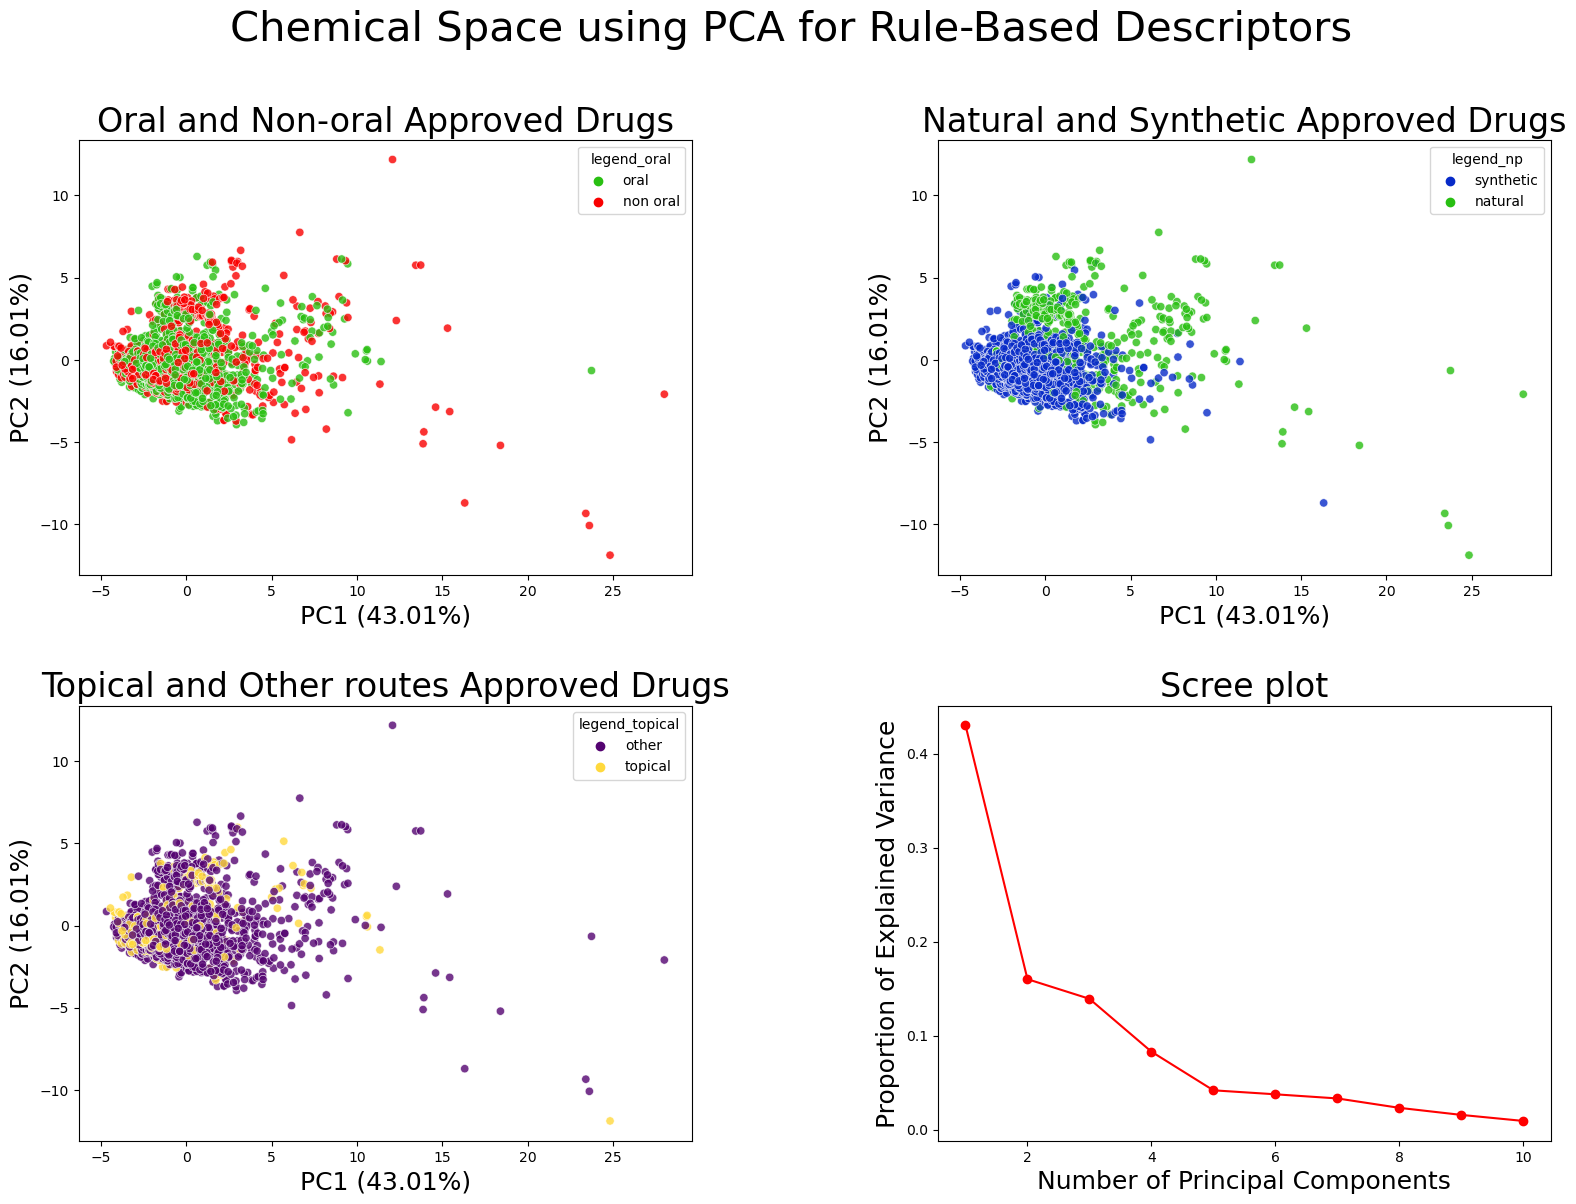

In [18]:
# PCA plots for oral/non oral, natural/synthetic, topical/other vs route drugs
VAR_PC1 = round(list(pca.explained_variance_ratio_)[0]*100, 2)
VAR_PC2 = round(list(pca.explained_variance_ratio_)[1]*100, 2)
TITLE_FONT_SIZE = 24
AXIS_LABEL_FONT_SIZE = 18

plt.tight_layout()
n_rows, n_cols = 2, 2
fig, axs = plt.subplots(n_rows, n_cols, figsize=(19,13))

palettes = {
    'oral': {'oral': '#29bf12', 'non oral': '#f90000'},
    'np': {'synthetic': '#072ac8', 'natural': '#28bf12'},
    'topical': {'topical': '#FFD93d', 'other':'#540371'}
}

plot_titles = {
    'oral': 'Oral and Non-oral Approved Drugs',
    'np': 'Natural and Synthetic Approved Drugs',
    'topical': 'Topical and Other routes Approved Drugs'
}

# PCA plots
for i, category in enumerate(['oral', 'np', 'topical']):
    row = i // n_cols
    col = i % n_cols

    sns.scatterplot(data=pca_rules_df, x='pc1', y='pc2', hue=f'legend_{category}', ax=axs[row][col],
    palette=palettes[category], alpha=.8)
    axs[row][col].set_title(plot_titles[category], fontsize=TITLE_FONT_SIZE)
    axs[row][col].set_xlabel(f'PC1 ({VAR_PC1}%)', fontsize=AXIS_LABEL_FONT_SIZE)
    axs[row][col].set_ylabel(f'PC2 ({VAR_PC2}%)', fontsize=AXIS_LABEL_FONT_SIZE)

# Screeplot
PC_values = np.arange(pca.n_components_) + 1
axs[1][1].plot(PC_values, pca.explained_variance_ratio_, 'ro-')
axs[1][1].set_title('Scree plot', fontsize=TITLE_FONT_SIZE)
axs[1][1].set_xlabel('Number of Principal Components', fontsize=AXIS_LABEL_FONT_SIZE)
axs[1][1].set_ylabel('Proportion of Explained Variance', fontsize=AXIS_LABEL_FONT_SIZE)

# Final adjustments
fig.subplots_adjust(wspace=0.4, hspace=0.3)
fig.suptitle('Chemical Space using PCA for Rule-Based Descriptors', fontsize=30)

#### Possible interpretation of Components

In [19]:
#### Attempt to interpret the Principal Components
for component in pca.components_[0:3]:
    print(list(zip(component, X_rule_based.columns))) 

[(0.29605348291007155, 'exactmw'), (0.29875547771066524, 'lipinskiHBA'), (0.21012491730677382, 'lipinskiHBD'), (0.17872343187769527, 'NumRotatableBonds'), (0.2231578572396419, 'NumHBD'), (0.2913715918202779, 'NumHBA'), (0.2960995165547765, 'NumHeavyAtoms'), (0.2786151190288417, 'NumAtoms'), (0.2865243632516041, 'NumHeteroatoms'), (0.15781847584291642, 'NumAmideBonds'), (0.0716729489122403, 'FractionCSP3'), (0.21146918921394942, 'NumRings'), (0.07195674991973638, 'NumAromaticRings'), (0.17596820971142016, 'NumAliphaticRings'), (0.15484706250675187, 'NumSaturatedRings'), (0.20944568747743647, 'NumHeterocycles'), (0.07857162048458821, 'NumAromaticHeterocycles'), (0.2000185395658344, 'NumAliphaticHeterocycles'), (0.11363027475716485, 'NumBridgeheadAtoms'), (0.21952943008940737, 'NumAtomStereoCenters'), (0.2803917973688747, 'tpsa'), (-0.015890907070100147, 'CrippenClogP')]
[(-0.012299387052979017, 'exactmw'), (-0.1564487172723632, 'lipinskiHBA'), (-0.1742973160614549, 'lipinskiHBD'), (-0.16

First component is basically a combination of all the stuff except complex rings. Second Component is basically about rings specially aliphatic and saturated rings;

## t-SNE

### All descriptors

In [20]:
# X matrix
X_all_descriptors = all_descriptors_dataset.iloc[:,:-1]

# Scaling/Normalizing data
scaler = StandardScaler()
scaler.fit(X_all_descriptors)
X_all_descriptors_scaled = scaler.transform(X_all_descriptors)

# PCA to reduce dimensionality
pca_30 = PCA(n_components=30)
pca_result_30 = pca_30.fit_transform(X_all_descriptors_scaled)
print(np.sum(pca_30.explained_variance_ratio_))

# t-SNE
tsne = TSNE(n_components=2, verbose=1, perplexity=70, n_iter=500)
tsne_results = tsne.fit_transform(pca_result_30)

0.740441404732188
[t-SNE] Computing 211 nearest neighbors...
[t-SNE] Indexed 1895 samples in 0.001s...
[t-SNE] Computed neighbors for 1895 samples in 0.343s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1895
[t-SNE] Computed conditional probabilities for sample 1895 / 1895
[t-SNE] Mean sigma: 4.019630
[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.924896
[t-SNE] KL divergence after 500 iterations: 1.092144


In [21]:
# Defining the labels
labels_mapping = {
    'oral': ['non oral', 'oral'],
    'natural_product_flag': ['synthetic', 'natural'],
    'topical': ['other', 'topical']
}

def create_legend_labels(column_name):
    return [labels_mapping[column_name][point] for point in response_variables[column_name]]

legend_oral = create_legend_labels('oral')
legend_np = create_legend_labels('natural_product_flag')
legend_topical = create_legend_labels('topical')

In [22]:
# Data dict and conversion to dataframe
data = {
    'tsne2d_1': tsne_results[:,0],
    'tsne2d_2': tsne_results[:,1],
    'legend_oral': legend_oral,
    'legend_np': legend_np,
    'legend_topical': legend_topical,
}
tsne_df = pd.DataFrame(data)

Text(0.5, 0.98, 'Chemical Space Visualization of FDA Approved Drugs \n(All Descriptors)')

<Figure size 640x480 with 0 Axes>

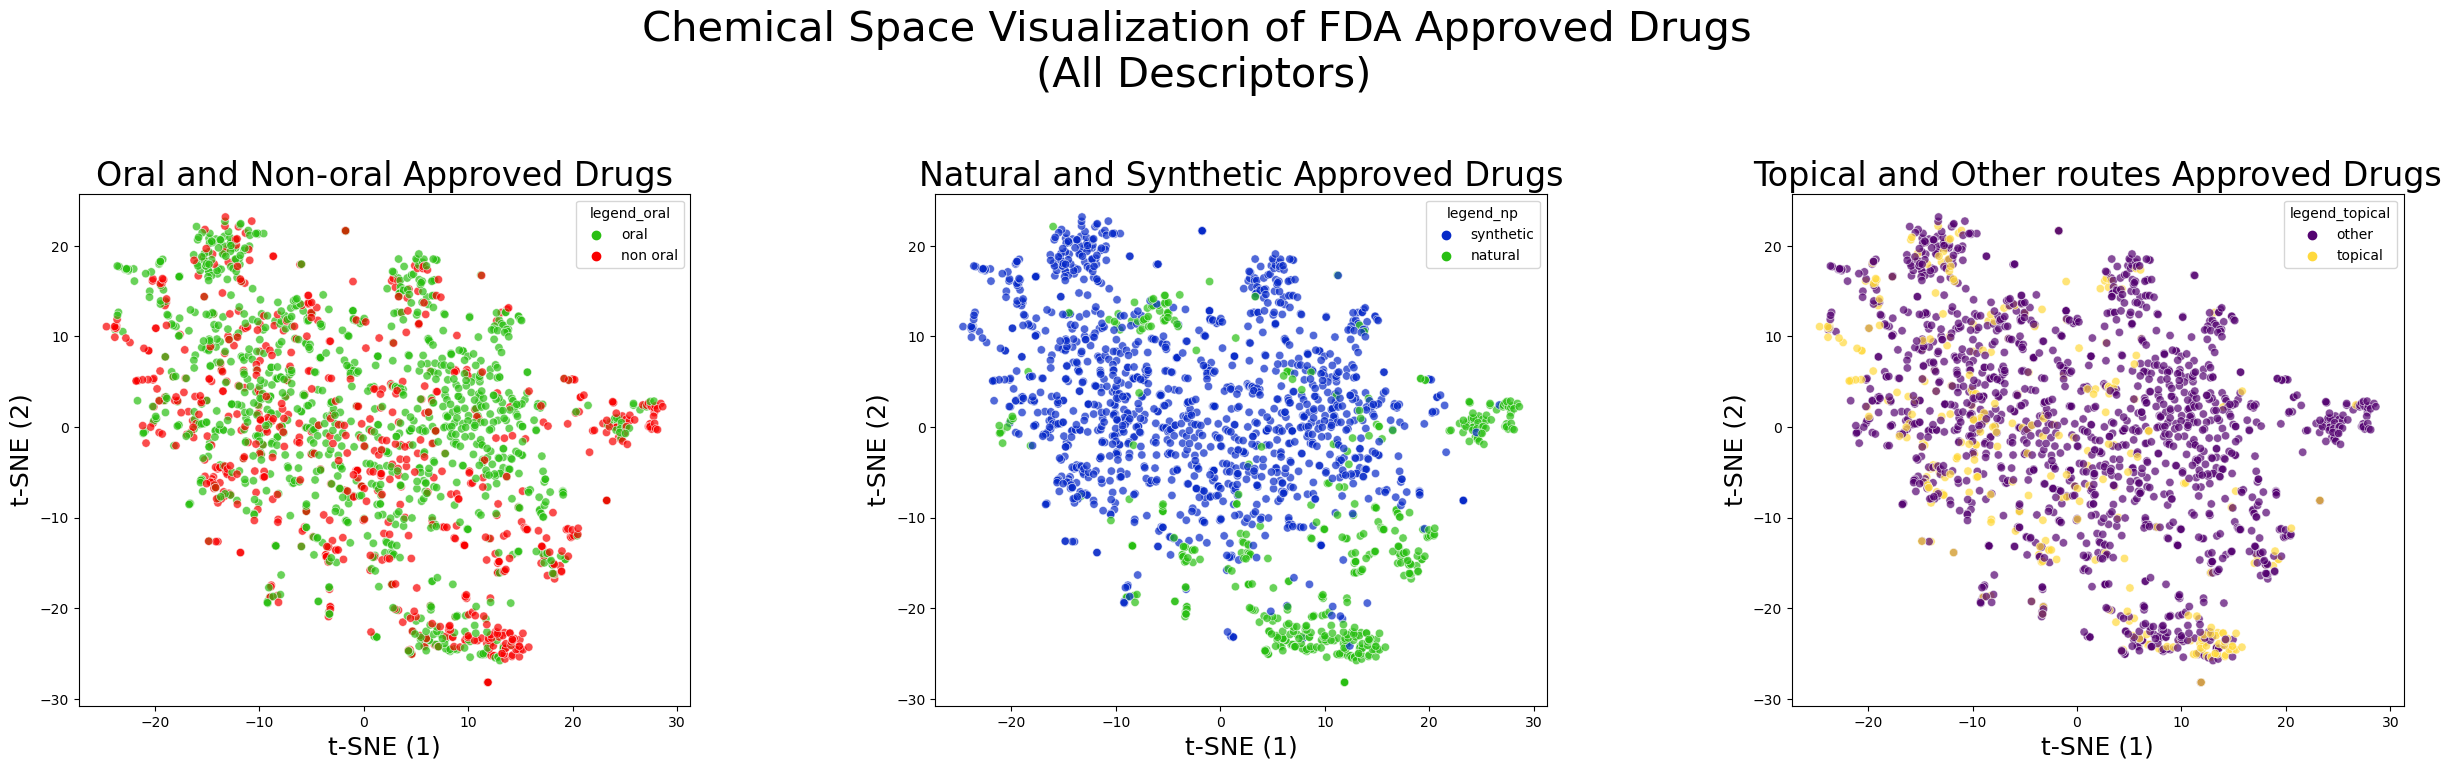

In [23]:
# t-SNE plots for oral/non-oral, natural/synthetic, topical/other
TITLE_FONT_SIZE = 24
AXIS_LABEL_FONT_SIZE = 18

plt.tight_layout()
fig, axs = plt.subplots(1,3, figsize=(30,8))

palettes = {
    'oral': {'oral': '#29bf12', 'non oral': '#f90000'},
    'np': {'synthetic': '#072ac8', 'natural': '#28bf12'},
    'topical': {'topical': '#FFD93d', 'other':'#540371'}
}

plot_titles = {
    'oral': 'Oral and Non-oral Approved Drugs',
    'np': 'Natural and Synthetic Approved Drugs',
    'topical': 'Topical and Other routes Approved Drugs'
}

# tsne plots
for i, category in enumerate(['oral', 'np', 'topical']):
    sns.scatterplot(data=tsne_df, x='tsne2d_1', y='tsne2d_2', hue=f'legend_{category}', ax=axs[i],
    palette=palettes[category], alpha=0.7)
    axs[i].set_title(plot_titles[category], fontsize=TITLE_FONT_SIZE)
    axs[i].set_xlabel('t-SNE (1)', fontsize=AXIS_LABEL_FONT_SIZE)
    axs[i].set_ylabel('t-SNE (2)', fontsize=AXIS_LABEL_FONT_SIZE)

# Final adjustments
plt.subplots_adjust(wspace=0.4, top=0.75)
fig.suptitle('Chemical Space Visualization of FDA Approved Drugs \n(All Descriptors)', fontsize=30)

### Rule-based

In [24]:
X_rule_based = rules_dataset.iloc[:,:-1]

# Scaling data
scaler = StandardScaler()
scaler.fit(X_rule_based)
X_rule_based_scaled = scaler.transform(X_rule_based)

# t-SNE
tsne = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=500)
tsne_results = tsne.fit_transform(X_rule_based_scaled)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 1895 samples in 0.002s...
[t-SNE] Computed neighbors for 1895 samples in 0.117s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1895
[t-SNE] Computed conditional probabilities for sample 1895 / 1895
[t-SNE] Mean sigma: 1.138931
[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.871750
[t-SNE] KL divergence after 500 iterations: 0.911277


In [25]:
# Defining the labels
labels_mapping = {
    'oral': ['non oral', 'oral'],
    'natural_product_flag': ['synthetic', 'natural'],
    'topical': ['other', 'topical']
}

def create_legend_labels(column_name):
    return [labels_mapping[column_name][point] for point in response_variables[column_name]]

legend_oral = create_legend_labels('oral')
legend_np = create_legend_labels('natural_product_flag')
legend_topical = create_legend_labels('topical')

In [26]:
data = {
    'tsne2d_1': tsne_results[:,0],
    'tsne2d_2': tsne_results[:,1],
    'legend_oral': legend_oral,
    'legend_np': legend_np,
    'legend_topical': legend_topical,
}
tsne_df = pd.DataFrame(data)

Text(0.5, 0.98, 'Chemical Space Visualization of FDA Approved Drugs \n(Rule-based Descriptors)')

<Figure size 640x480 with 0 Axes>

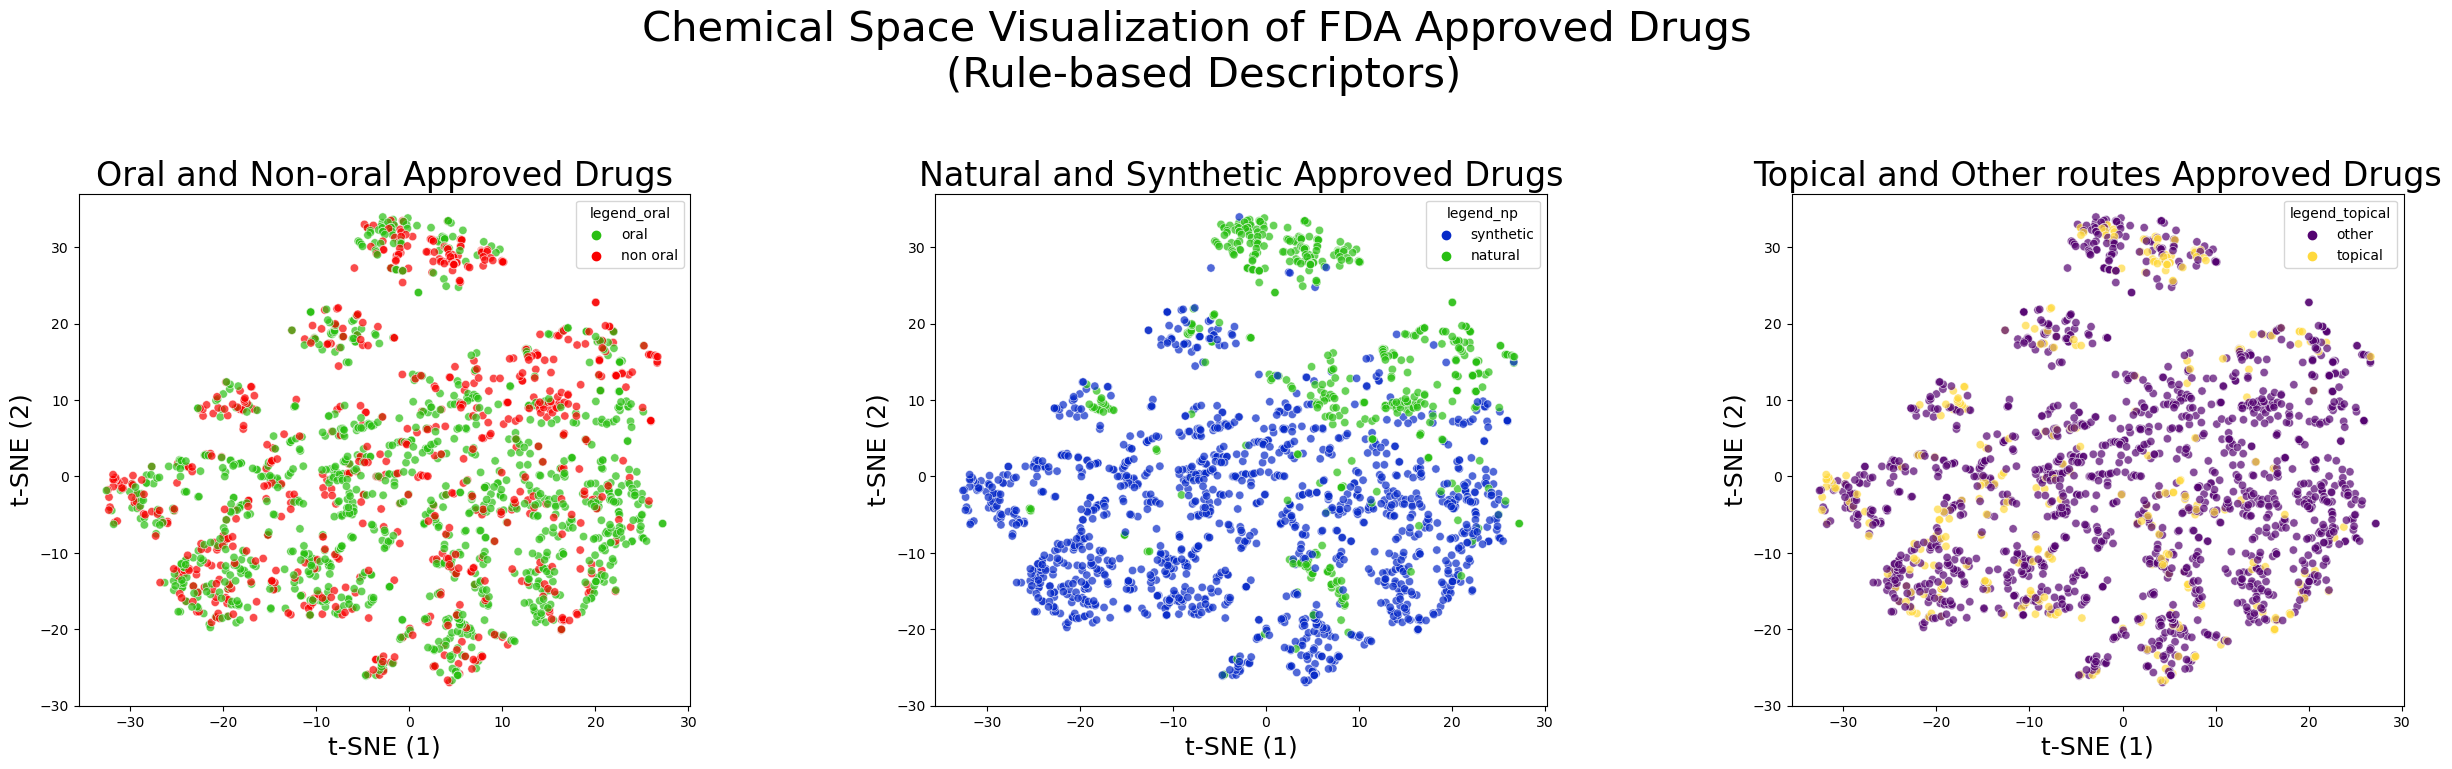

In [27]:
# t-SNE plots for oral/non-oral, natural/synthetic, topical/other
TITLE_FONT_SIZE = 24
AXIS_LABEL_FONT_SIZE = 18

plt.tight_layout()
fig, axs = plt.subplots(1,3, figsize=(30,8))

palettes = {
    'oral': {'oral': '#29bf12', 'non oral': '#f90000'},
    'np': {'synthetic': '#072ac8', 'natural': '#28bf12'},
    'topical': {'topical': '#FFD93d', 'other':'#540371'}
}

plot_titles = {
    'oral': 'Oral and Non-oral Approved Drugs',
    'np': 'Natural and Synthetic Approved Drugs',
    'topical': 'Topical and Other routes Approved Drugs'
}

# tsne plots
for i, category in enumerate(['oral', 'np', 'topical']):
    sns.scatterplot(data=tsne_df, x='tsne2d_1', y='tsne2d_2', hue=f'legend_{category}', ax=axs[i],
    palette=palettes[category], alpha=0.7)
    axs[i].set_title(plot_titles[category], fontsize=TITLE_FONT_SIZE)
    axs[i].set_xlabel('t-SNE (1)', fontsize=AXIS_LABEL_FONT_SIZE)
    axs[i].set_ylabel('t-SNE (2)', fontsize=AXIS_LABEL_FONT_SIZE)

# Final adjustments
plt.subplots_adjust(wspace=0.4, top=0.75)
fig.suptitle('Chemical Space Visualization of FDA Approved Drugs \n(Rule-based Descriptors)', fontsize=30)